[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  1  1  1  1  1  1  1  1  2  2  3  2  2
  2  2  1  1  2  3  3  1  2  1  1  3  2  2  3  4  2  1  2  4  3  3  2  1
  3  4  4  4  5  1  1  5  1  2  1  2  3  1  1  5  3  1  2  1  5  5  5  7
 11  7 15  4  3  5  8 11  9  3  3  7 12 13  5  8  3 22 22 16 13  6  3 16
  2  4  2 11  4 24 38 19 31 29 11 17 43 14 60 50 25 45  7 13 11  5 17 60
 31  4  3  2 16  8 18  1  2  5 10  4  1  1  6  2 27  1 17  1  2  4  1  4
  1 12  7  2  1  2  1  1  1  2  5  2  2  2  1  4  1  2  2  3  4  3  1  1
  4  1  2  2  5  2 10  1  2  9  4  4  1  1  2  2  1  2  1  2  2  4  1  3
  2  6  3  2  2  2  2  2  2  4  2  2  2  3  6  5  4  4  4  5  3  4  4  3
  3  2 27 15 10  3  3  4  2  5  3  2  4  4  3  5  3  4  4  5  6  6  3  5
  6 10  4  9 12 43  7 10  4 25  9  7  9  4  7  9  6  5  6  6  7  6  6 15
  6 20 12 17 17  8  9 12  8  8 11  9 11  9  9 12 15

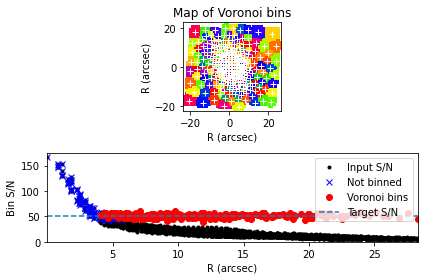

In [1]:
from os import path
import numpy as np
import matplotlib.pyplot as plt

import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning




#-----------------------------------------------------------------------------

def voronoi_binning_example():
    """
    Usage example for the procedure VORONOI_2D_BINNING.

    It is assumed below that the file voronoi_2d_binning_example.txt
    resides in the current directory. Here columns 1-4 of the text file
    contain respectively the x, y coordinates of each SAURON lens
    and the corresponding Signal and Noise.

    """
    file_dir = path.dirname(path.realpath(vorbin.__file__))  # path of vorbin
    x, y, signal, noise = np.loadtxt(file_dir + '/example/voronoi_2d_binning_example_input.txt').T
    target_sn = 50.0
    # Perform the actual computation. The vectors
    # (binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale)
    # are all generated in *output*
    #
    binNum, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, signal, noise, target_sn, plot=1, quiet=1)
    print(nPixels)
#     print(np.shape(binNum))
#     print(len(np.unique(binNum)))
#     print(binNum)
#     print(np.unique(binNum))
#     for i, inum in enumerate(np.unique(binNum)):
#         print(i, inum)
    # print(x_gen)
    # Save to a text file the initial coordinates of each pixel together
    # with the corresponding bin number computed by this procedure.
    # binNum uniquely specifies the bins and for this reason it is the only
    # number required for any subsequent calculation on the bins.
    #
#     np.savetxt('voronoi_2d_binning_example_output.txt', np.column_stack([x, y, binNum]),
#                fmt=b'%10.6f %10.6f %8i')

#-----------------------------------------------------------------------------
    
if __name__ == '__main__':

    voronoi_binning_example()
    plt.tight_layout()
    # plt.pause(1)

In [2]:
np.meshgrid(np.arange(10), np.arange(10))
comb_array = np.array(np.meshgrid(np.arange(2), np.arange(3))).T.reshape(-1, 2)
s = np.array([[1, 2, 5], [3, 4, 8]])
n = np.array([[-1, -2, -5], [-3, -4, -8]])
sn_array = np.array([s, n]).T.reshape(-1, 2)
print(sn_array)
print(comb_array[:, 0])
print(comb_array[:, 1])


print(comb_array)
x = np.zeros((10, 4, 4))
x[0, 1, 2] = 2
print(np.shape(np.mean(x, axis=(0))))

[[ 1 -1]
 [ 3 -3]
 [ 2 -2]
 [ 4 -4]
 [ 5 -5]
 [ 8 -8]]
[0 0 0 1 1 1]
[0 1 2 0 1 2]
[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]]
(4, 4)


(81, 200, 200)
(33, 200, 200)
(200, 200)
(200, 200)
115.21506392805345
148.4049329724411


/Users/lzq/anaconda3/envs/astroconda/lib/python3.7/site-packages/vorbin/voronoi_2d_binning.py:277: RuntimeWarning: invalid value encountered in sqrt
  scale[k] = np.sqrt(index.size/sn)  # Eq. (4) of Diehl & Statler (2006)


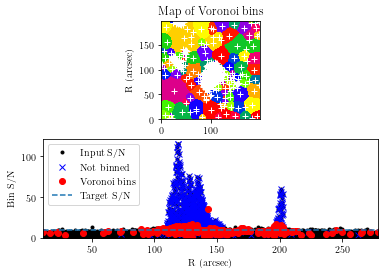

In [17]:
import os
import lmfit
import vorbin
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.table import Table
from matplotlib import rc
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from PyAstronomy import pyasl
from mpdaf.obj import Cube, WCS, WaveCoord, iter_spe, iter_ima
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
rc('text', usetex=True)


def getSigma_MUSE(wave):
    return (5.866e-8 * wave ** 2 - 9.187e-4 * wave + 6.04) / 2.355

def model_OII(wave_vac, z, sigma_kms, flux_OII, r_OII3729_3727, a, b):
    # Constants
    c_kms = 2.998e5
    wave_OII3727_vac = 3727.092
    wave_OII3729_vac = 3729.875

    wave_OII3727_obs = wave_OII3727_vac * (1 + z)
    wave_OII3729_obs = wave_OII3729_vac * (1 + z)

    sigma_OII3727_A = np.sqrt((sigma_kms / c_kms * wave_OII3727_obs) ** 2 + (getSigma_MUSE(wave_OII3727_obs)) ** 2)
    sigma_OII3729_A = np.sqrt((sigma_kms / c_kms * wave_OII3729_obs) ** 2 + (getSigma_MUSE(wave_OII3729_obs)) ** 2)

    flux_OII3727 = flux_OII / (1 + r_OII3729_3727)
    flux_OII3729 = flux_OII / (1 + 1.0 / r_OII3729_3727)

    peak_OII3727 = flux_OII3727 / np.sqrt(2 * sigma_OII3727_A ** 2 * np.pi)
    peak_OII3729 = flux_OII3729 / np.sqrt(2 * sigma_OII3729_A ** 2 * np.pi)

    OII3727_gaussian = peak_OII3727 * np.exp(-(wave_vac - wave_OII3727_obs) ** 2 / 2 / sigma_OII3727_A ** 2)
    OII3729_gaussian = peak_OII3729 * np.exp(-(wave_vac - wave_OII3729_obs) ** 2 / 2 / sigma_OII3729_A ** 2)

    return OII3727_gaussian + OII3729_gaussian + a * wave_vac + b


def model_Hbeta(wave_vac, z, sigma_kms, flux_Hbeta, a, b):
    # Constants
    c_kms = 2.998e5
    wave_Hbeta_vac = 4862.721

    wave_Hbeta_obs = wave_Hbeta_vac * (1 + z)
    sigma_Hbeta_A = np.sqrt((sigma_kms / c_kms * wave_Hbeta_obs) ** 2 + (getSigma_MUSE(wave_Hbeta_obs)) ** 2)

    peak_Hbeta = flux_Hbeta / np.sqrt(2 * sigma_Hbeta_A ** 2 * np.pi)
    Hbeta_gaussian = peak_Hbeta * np.exp(-(wave_vac - wave_Hbeta_obs) ** 2 / 2 / sigma_Hbeta_A ** 2)

    return Hbeta_gaussian + a * wave_vac + b


def model_OIII4960(wave_vac, z, sigma_kms, flux_OIII4960, a, b):
    # Constants
    c_kms = 2.998e5
    wave_OIII4960_vac = 4960.295

    wave_OIII4960_obs = wave_OIII4960_vac * (1 + z)
    sigma_OIII4960_A = np.sqrt((sigma_kms / c_kms * wave_OIII4960_obs) ** 2 + (getSigma_MUSE(wave_OIII4960_obs)) ** 2)

    peak_OIII4960 = flux_OIII4960 / np.sqrt(2 * sigma_OIII4960_A ** 2 * np.pi)
    OIII4960_gaussian = peak_OIII4960 * np.exp(-(wave_vac - wave_OIII4960_obs) ** 2 / 2 / sigma_OIII4960_A ** 2)

    return OIII4960_gaussian + a * wave_vac + b


def model_OIII5008(wave_vac, z, sigma_kms, flux_OIII5008, a, b):
    # Constants
    c_kms = 2.998e5
    wave_OIII5008_vac = 5008.239

    wave_OIII5008_obs = wave_OIII5008_vac * (1 + z)
    sigma_OIII5008_A = np.sqrt((sigma_kms / c_kms * wave_OIII5008_obs) ** 2 + (getSigma_MUSE(wave_OIII5008_obs)) ** 2)

    peak_OIII5008 = flux_OIII5008 / np.sqrt(2 * sigma_OIII5008_A ** 2 * np.pi)
    OIII5008_gaussian = peak_OIII5008 * np.exp(-(wave_vac - wave_OIII5008_obs) ** 2 / 2 / sigma_OIII5008_A ** 2)

    return OIII5008_gaussian + a * wave_vac + b


# def model_all(wave_vac, z, sigma_kms_OII, sigma_kms_Hbeta, sigma_kms_OIII4960, sigma_kms_OIII5008, flux_OII,
#               flux_Hbeta, flux_OIII4960, flux_OIII5008, r_OII3729_3727, a_OII, b_OII, a_Hbeta, b_Hbeta,
#               a_OIII4960, b_OIII4960, a_OIII5008, b_OIII5008):
def model_all(wave_vac, z, sigma_kms, flux_OII, flux_Hbeta, flux_OIII5008, r_OII3729_3727, a_OII, b_OII, a_Hbeta,
              b_Hbeta, a_OIII4960, b_OIII4960, a_OIII5008, b_OIII5008):

    m_OII = model_OII(wave_vac[0], z, sigma_kms, flux_OII, r_OII3729_3727, a_OII, b_OII)
    m_Hbeta = model_Hbeta(wave_vac[1], z, sigma_kms, flux_Hbeta, a_Hbeta, b_Hbeta)
    m_OIII4960 = model_OIII4960(wave_vac[2], z, sigma_kms, flux_OIII5008 / 3, a_OIII4960, b_OIII4960)
    m_OIII5008 = model_OIII5008(wave_vac[3], z, sigma_kms, flux_OIII5008, a_OIII5008, b_OIII5008)
    return np.hstack((m_OII, m_Hbeta, m_OIII4960, m_OIII5008))

# Fitting the narrow band image profile
path_cube_OII = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_OII_line_offset.fits')
path_cube_Hbeta = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_Hbeta_line_offset.fits')
path_cube_OIII4960 = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_OIII_4960_line_offset.fits')
path_cube_OIII5008 = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_OIII_5008_line_offset.fits')
cube_OII = Cube(path_cube_OII)
cube_Hbeta = Cube(path_cube_Hbeta)
cube_OIII4960 = Cube(path_cube_OIII4960)
cube_OIII5008 = Cube(path_cube_OIII5008)
# cube_OII = cube_OII.subcube((80, 100), 80, unit_center=None, unit_size=None)
# cube_Hbeta = cube_Hbeta.subcube((80, 100), 80, unit_center=None, unit_size=None)
# cube_OIII4960 = cube_OIII4960.subcube((80, 100), 80, unit_center=None, unit_size=None)
# cube_OIII5008 = cube_OIII5008.subcube((80, 100), 80, unit_center=None, unit_size=None)
cube_OIII5008[0, :, :].write('/Users/lzq/Dropbox/Data/CGM/image_OOHbeta_fitline.fits')

redshift_guess = 0.63
sigma_kms_guess = 150.0
# flux_OIII5008_guess = 0.01
r_OII3729_3727_guess = 2

parameters = lmfit.Parameters()
parameters.add_many(('z', redshift_guess, True, 0.62, 0.64, None),
                    ('sigma_kms', sigma_kms_guess, True, 10, 500, None),
                    ('flux_OII', 0.01, True, None, None, None),
                    ('flux_Hbeta', 0.02, True, None, None, None),
                    ('flux_OIII5008', 0.1, True, None, None, None),
                    ('r_OII3729_3727', r_OII3729_3727_guess, True, 0.2, None, None),
                    ('a_OII', 0.0, False, None, None, None),
                    ('b_OII', 0.0, False, None, None, None),
                    ('a_Hbeta', 0.0, False, None, None, None),
                    ('b_Hbeta', 0.0, False, None, None, None),
                    ('a_OIII4960', 0.0, False, None, None, None),
                    ('b_OIII4960', 0.0, False, None, None, None),
                    ('a_OIII5008', 0.0, False, None, None, None),
                    ('b_OIII5008', 0.0, False, None, None, None))


num_lines = 4
size = np.shape(cube_OII)[1]
fit_success = np.zeros((size, size))
r_fit, dr_fit = np.zeros((size, size)), np.zeros((size, size))
z_fit, dz_fit = np.zeros((size, size)), np.zeros((size, size))
sigma_fit, dsigma_fit = np.zeros((size, size)), np.zeros((size, size))
flux_fit, dflux_fit = np.zeros((3, size, size)), np.zeros((3, size, size))
a_fit, b_fit = np.zeros((num_lines, size, size)), np.zeros((num_lines, size, size))
da_fit, db_fit = np.zeros((num_lines, size, size)), np.zeros((num_lines, size, size))

#
wave_OII_vac = pyasl.airtovac2(cube_OII.wave.coord())
wave_Hbeta_vac = pyasl.airtovac2(cube_Hbeta.wave.coord())
wave_OIII4960_vac = pyasl.airtovac2(cube_OIII4960.wave.coord())
wave_OIII5008_vac = pyasl.airtovac2(cube_OIII5008.wave.coord())
wave_vac_all = np.array([wave_OII_vac, wave_Hbeta_vac, wave_OIII4960_vac, wave_OIII5008_vac], dtype=object)

# Data of each pixel
flux_OII, flux_Hbeta = cube_OII.data * 1e-3, cube_Hbeta.data * 1e-3
flux_OIII4960, flux_OIII5008 = cube_OIII4960.data * 1e-3, cube_OIII5008.data * 1e-3
flux_OII_err, flux_Hbeta_err = np.sqrt(cube_OII.var) * 1e-3, np.sqrt(cube_Hbeta.var) * 1e-3
flux_OIII4960_err = np.sqrt(cube_OIII4960.var) * 1e-3
flux_OIII5008_err = np.sqrt(cube_OIII5008.var) * 1e-3
print(np.shape(flux_OII))
flux_all = np.vstack((flux_OII, flux_Hbeta, flux_OIII4960, flux_OIII5008))
flux_err_all = np.vstack((flux_OII_err, flux_Hbeta_err, flux_OIII4960_err, flux_OIII5008_err))


# Voronoi binning
xy_array = np.array(np.meshgrid(np.arange(size), np.arange(size))).T.reshape(-1, 2) 

# Compute noises
# Signal
OIII5008_data = cube_OIII5008.select_lambda(8140, 8180).data * 1e-3
print(np.shape(OIII5008_data))
OIII5008_sig = np.sum(OIII5008_data, axis=0)

# Noise #1
OIII5008_err = np.sqrt(cube_OIII5008.select_lambda(8140, 8180).var) * 1e-3
OIII5008_err_int = np.sqrt(np.sum(OIII5008_err ** 2, axis=0))
print(np.shape(OIII5008_err_int))

# Noise #2
OIII5008_std = np.std(cube_OIII5008.select_lambda(8180, 8200).data * 1e-3, axis=0) * np.sqrt(np.shape(OIII5008_data)[0])
print(np.shape(OIII5008_std))

# 
sn_array_1 = np.array([OIII5008_sig, OIII5008_err_int]).T.reshape(-1, 2)
sn_array_2 = np.array([OIII5008_sig, OIII5008_std]).T.reshape(-1, 2)

target_sn = 10
print(np.max(OIII5008_sig / OIII5008_err_int))
print(np.max(OIII5008_sig / OIII5008_std))
binNum_1, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = voronoi_2d_binning(xy_array[:, 0], xy_array[:, 1], sn_array_1[:, 0], sn_array_1[:, 1], target_sn, pixelsize=1, plot=1, quiet=1)
plt.show()
#print(binNum[500:600])
# binNum_2, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = voronoi_2d_binning(xy_array[:, 0], xy_array[:, 1], sn_array_1[:, 0], sn_array_1[:, 1], target_sn, pixelsize=None, plot=1, quiet=1)
# print(len(np.unique(binNum)))
# print(np.sum(binNum_2 - binNum_1))


In [4]:
y = np.array([[1, 2, 5, 6], [3, 4, 8, 9], [4, 5, 6, 7], [8, 9, 10, 15]])
x_1 = np.array([1, 1, 2, 3])
x_2 = np.array([0, 1, 1, 3])
print(y)
y[x_1, x_2].sum()
y[x_1, x_2]

[[ 1  2  5  6]
 [ 3  4  8  9]
 [ 4  5  6  7]
 [ 8  9 10 15]]


array([ 3,  4,  5, 15])

In [5]:
import os
import numpy as np
from mpdaf.obj import Cube, WCS, WaveCoord, iter_spe

# Load the data
path = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_OIII_5008_line_offset.fits')
cube_OIII_5008_line = Cube(path)

image_OIII_5008_line = cube_OIII_5008_line.sum(axis=0) * 1.25 * 1e-20 / 0.2 / 0.2  # put into SB units
print(np.std(image_OIII_5008_line[20:30, 20:30].data))
noise_OIII_5008_line = np.std(image_OIII_5008_line[10:20, 10:20].data)
sn_OIII_5008_line = image_OIII_5008_line / noise_OIII_5008_line

sn_OIII_5008_line.write('/Users/lzq/Dropbox/Data/CGM/SN_OIII_5008_line_SB_offset.fits')

5.580495270861327e-18


In [6]:
# import os
# import aplpy
# import numpy as np
# import matplotlib as mpl
# import astropy.io.fits as fits
# import matplotlib.pyplot as plt
# from matplotlib import rc
# from matplotlib import cm
# from astropy import units as u
# from muse_compare_z import compare_z
# from matplotlib.colors import ListedColormap
# from vorbin.voronoi_2d_binning import voronoi_2d_binning
# rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
# rc('text', usetex=True)
# mpl.rcParams['xtick.direction'] = 'in'
# mpl.rcParams['ytick.direction'] = 'in'
# mpl.rcParams['xtick.major.size'] = 10
# mpl.rcParams['ytick.major.size'] = 10

# # Cmap
# Blues = cm.get_cmap('Blues', 256)
# Reds = cm.get_cmap('Reds', 256)
# newcolors = Blues(np.linspace(0, 1, 256))
# newcolors_red = Reds(np.linspace(0, 1, 256))
# newcmp = ListedColormap(newcolors)

# def ConvertFits(filename=None, table=None):
#     path = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', filename + '.fits')
#     data, hdr = fits.getdata(path, 1, header=True)
    
    
#     fits.writeto('/Users/lzq/Dropbox/Data/CGM/' + filename + '_revised.fits', table, overwrite=True)
#     data1, hdr1 = fits.getdata('/Users/lzq/Dropbox/Data/CGM/' + filename + '_revised.fits', 0, header=True)
#     hdr1['BITPIX'], hdr1['NAXIS'], hdr1['NAXIS1'], hdr1['NAXIS2'] = hdr['BITPIX'], hdr['NAXIS'], \
#                                                                     hdr['NAXIS1'], hdr['NAXIS2']
#     hdr1['CRPIX1'], hdr1['CRPIX2'], hdr1['CTYPE1'], hdr1['CTYPE2'] = hdr['CRPIX1'], hdr['CRPIX2'], \
#                                                                      hdr['CTYPE1'], hdr['CTYPE2']
#     hdr1['CRVAL1'], hdr1['CRVAL2'], hdr1['LONPOLE'], hdr1['LATPOLE'] = hdr['CRVAL1'], hdr['CRVAL2'], \
#                                                                        hdr['LONPOLE'], hdr['LATPOLE']
#     hdr1['CSYER1'], hdr1['CSYER2'], hdr1['MJDREF'], hdr1['RADESYS'] = hdr['CSYER1'], hdr['CSYER2'], \
#                                                                       hdr['MJDREF'], hdr['RADESYS']
#     hdr1['CD1_1'], hdr1['CD1_2'], hdr1['CD2_1'], hdr1['CD2_2'] = hdr['CD1_1'], hdr['CD1_2'], hdr['CD2_1'], hdr['CD2_2']
#     # Rescale the data by 1e17
#     fits.writeto('/Users/lzq/Dropbox/Data/CGM/' + filename + '_revised.fits', data1, hdr1, overwrite=True)
    
    

# def PlotMap(line='OIII', check=False, test=True, snr_thr=3, row=None, z=None, ra=None, dec=None):
#     # Load OIII
#     if test is True:
#         path_fit_info = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM',
#                                      'fit' + line + '_info_test.fits')
#         path_fit_info_err = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM',
#                                          'fit' + line + '_info_err_test.fits')
#     else:
#         path_fit_info = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM',
#                                      'fit' + line + '_info.fits')
#         path_fit_info_err = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM',
#                                          'fit' + line + '_info_err.fits')
#     fit_info = fits.getdata(path_fit_info, 0, ignore_missing_end=True)
#     fit_info_err = fits.getdata(path_fit_info_err, 0, ignore_missing_end=True)

#     if line == 'OOHbeta':
#         # [z_fit, r_fit, sigma_fit_OII, sigma_fit_Hbeta, sigma_fit_OIII4960, sigma_fit_OIII5008,
#         #  flux_fit_OII, flux_fit_Hbeta, flux_fit_OIII4960, flux_fit_OIII5008, a_fit_OII, a_fit_Hbeta,
#         #  a_fit_OIII4960, a_fit_OIII5008, b_fit_OII, b_fit_Hbeta, b_fit_OIII4960, b_fit_OIII5008] = fit_info
#         # [dz_fit, dr_fit, dsigma_fit_OII, dsigma_fit_Hbeta, dsigma_fit_OIII4960, dsigma_fit_OIII5008,
#         #  dflux_fit_OII, dflux_fit_Hbeta, dflux_fit_OIII4960, dflux_fit_OIII5008, da_fit_OII, da_fit_Hbeta,
#         #  da_fit_OIII4960, da_fit_OIII5008, db_fit_OII, db_fit_Hbeta, db_fit_OIII4960, db_fit_OIII5008] = fit_info_err

#         [z_fit, r_fit, fit_success, sigma_fit, flux_fit_OII, flux_fit_Hbeta, flux_fit_OIII5008, a_fit_OII, a_fit_Hbeta,
#          a_fit_OIII4960, a_fit_OIII5008, b_fit_OII, b_fit_Hbeta, b_fit_OIII4960, b_fit_OIII5008] = fit_info
#         [dz_fit, dr_fit, dsigma_fit, dflux_fit_OII, dflux_fit_Hbeta, dflux_fit_OIII5008, da_fit_OII, da_fit_Hbeta,
#          da_fit_OIII4960, da_fit_OIII5008, db_fit_OII, db_fit_Hbeta, db_fit_OIII4960, db_fit_OIII5008] = fit_info_err
#     elif line == 'OII':
#         [z_fit, sigma_fit, flux_fit, fit_success, r_fit, a_fit, b_fit] = fit_info
#         [dz_fit, dsigma_fit, dflux_fit, dr_fit, da_fit, db_fit] = fit_info_err
#     else:
#     # Load data
#         [z_fit, sigma_fit, flux_fit, fit_success, a_fit, b_fit] = fit_info
#         [dz_fit, dsigma_fit, dflux_fit, da_fit, db_fit] = fit_info_err
#     z_qso = 0.6282144177077355
#     v_fit = 3e5 * (z_fit - z_qso) / (1 + z_qso)
#     v_gal = 3e5 * (z - z_qso) / (1 + z_qso)
    
#     x, y = 
#     signal, noise = 
#     target_sn
#     binNum, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = voronoi_2d_binning(
#         x, y, signal, noise, target_sn, plot=1, quiet=0)
        
#     # Check consistency
#     if check is True:
#         plt.figure(figsize=(8, 8), dpi=300)
#         plt.imshow(v_fit, cmap='coolwarm', vmin=-300, vmax=300, origin='lower')
#         plt.show()

#     if line == 'OOHbeta':
#         flux_stack = np.stack((flux_fit_OII, flux_fit_Hbeta, flux_fit_OIII5008), axis=0)
#         dflux_stack = np.stack((dflux_fit_OII, dflux_fit_Hbeta, dflux_fit_OIII5008), axis=0)
#         fit_max = np.amax(flux_stack / dflux_stack, axis=0)
#         v_fit = np.where((fit_max > snr_thr), v_fit, np.nan)
#         ConvertFits(filename='image_' + line + '_fitline', table=v_fit)

#     else:
#         # Final data
#         v_fit = np.where((flux_fit / dflux_fit > snr_thr), v_fit, np.nan)
#         ConvertFits(filename='image_' + line + '_fitline', table=v_fit)

#     # Plot
#     fig = plt.figure(figsize=(8, 8), dpi=300)
#     path_dv = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'image_' + line + '_fitline_revised.fits')
#     gc = aplpy.FITSFigure(path_dv, figure=fig, north=True)
#     gc.set_system_latex(True)
#     gc.show_colorscale(vmin=-300, vmax=300, cmap='coolwarm')
#     gc.add_colorbar()
#     gc.ticks.set_length(30)
#     gc.show_markers(40.1359, -18.8643, facecolors='none', marker='*', c='none', edgecolors='k', linewidths=0.5, s=250)
#     gc.show_markers(ra, dec, facecolor='none', marker='o', c='none', edgecolors='k', linewidths=0.8, s=100)
#     gc.show_markers(ra, dec, marker='o', c=v_gal, linewidths=0.5, s=40, vmin=-300, vmax=300, cmap='coolwarm')
#     # gc.show_regions('/Users/lzq/Dropbox/Data/CGM/galaxy_list.reg')
#     gc.colorbar.set_location('bottom')
#     gc.colorbar.set_pad(0.)
#     gc.colorbar.set_axis_label_text(r'$\mathrm{\Delta v \; [km \, s^{-1}]}$')
#     gc.colorbar.set_font(size=15)
#     gc.colorbar.set_axis_label_font(size=15)
#     gc.add_scalebar(length=15 * u.arcsecond)
#     gc.scalebar.set_corner('top left')
#     gc.scalebar.set_label(r"$15'' \approx 100 \mathrm{\; pkpc}$")
#     gc.scalebar.set_font_size(15)
#     gc.ticks.hide()
#     gc.tick_labels.hide()
#     gc.axis_labels.hide()

#     for i in range(len(row)):
#         gc.add_label(ra[i] + 0.00014, dec[i] - 0.00008, "{0:.0f}".format(v_gal[i]), size=10, horizontalalignment='right'
#                      , verticalalignment='bottom')
#     # label
#     if line == 'OIII':
#         gc.add_label(0.80, 0.97, r'$\Delta v = v_{\mathrm{[O \, III]}} - v_{\mathrm{qso}}$', size=15, relative=True)
#     elif line == 'OII':
#         gc.add_label(0.80, 0.97, r'$\Delta v = v_{\mathrm{[O \, II]}} - v_{\mathrm{qso}}$', size=15, relative=True)
#     elif line == 'OOHbeta':
#         gc.add_label(0.80, 0.97, r'$\Delta v = v_{\mathrm{[OOH \beta]}} - v_{\mathrm{qso}}$', size=15, relative=True)
#     xw, yw = gc.pixel2world(195, 150)
#     gc.show_arrows(xw, yw, -0.00005 * yw, 0, color='k')
#     gc.show_arrows(xw, yw, 0, -0.00005 * yw, color='k')
#     gc.add_label(0.9775, 0.85, r'N', size=15, relative=True)
#     gc.add_label(0.88, 0.75, r'E', size=15, relative=True)
#     fig.savefig('/Users/lzq/Dropbox/Data/CGM_plots/' + line + '_dv_map.png', bbox_inches='tight')


# # Load galxies infomation
# ggp_info = compare_z(cat_sean='ESO_DEEP_offset_zapped_objects_sean.fits',
#                      cat_will='ESO_DEEP_offset_zapped_objects.fits')
# row_final = ggp_info[1]
# ID_final = ggp_info[2]
# z_final = ggp_info[3]
# name_final = ggp_info[5]
# ra_final = ggp_info[7]
# dec_final = ggp_info[8]

# col_ID = np.arange(len(row_final))
# select_array = np.sort(np.array([6, 7, 181, 182, 80, 81, 82, 179, 4, 5, 64]))
# select_gal = np.in1d(row_final, select_array)
# row_final = row_final[select_gal]
# z_final = z_final[select_gal]
# ra_final = ra_final[select_gal]
# dec_final = dec_final[select_gal]

# # run
# # PlotMap(line='OII', check=False, snr_thr=2.5, row=row_final, z=z_final, ra=ra_final, dec=dec_final)
# # PlotMap(line='OIII', snr_thr=3, row=row_final, z=z_final, ra=ra_final, dec=dec_final)
# PlotMap(line='OOHbeta', snr_thr=4, check=True, row=row_final, z=z_final, ra=ra_final, dec=dec_final)
    
